In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd //content/drive/MyDrive/Digital_Image_Processing_Regression_Classification/data/Canny_edge_detection/Code

/content/drive/MyDrive/Digital_Image_Processing_Regression_Classification/data/Canny_edge_detection/Code


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy import signal
from PIL import Image
import argparse

# Copy the path of the folder that contains this notebook using the file navigation on the left:
# Ex. /content/drive/My\ Drive/CIS 581-Online/Canny Edge Project/Learner Code and Images/Code
sys.path.append('')

# import functions
from helpers import interp2, edgeLink

# Tests and Visualization

In [4]:
def Test_script(I, E):
    test_pass = True

    # E should be 2D matrix
    if E.ndim != 2:
      print('ERROR: Incorrect Edge map dimension! \n')
      print(E.ndim)
      test_pass = False
    # end if

    # E should have same size with original image
    nr_I, nc_I = I.shape[0], I.shape[1]
    nr_E, nc_E = E.shape[0], E.shape[1]

    if nr_I != nr_E or nc_I != nc_E:
      print('ERROR: Edge map size has changed during operations! \n')
      test_pass = False
    # end if

    # E should be a binary matrix so that element should be either 1 or 0
    numEle = E.size
    numOnes, numZeros = E[E == 1].size, E[E == 0].size

    if numEle != (numOnes + numZeros):
      print('ERROR: Edge map is not binary one! \n')
      test_pass = False
    # end if

    if test_pass:
      print('Shape Test Passed! \n')
    else:
      print('Shape Test Failed! \n')

    return test_pass

In [5]:
'''
  Derivatives visualzation function
'''
def visDerivatives(I_gray, Mag, Magx, Magy):
    fig, (Ax0, Ax1, Ax2, Ax3) = plt.subplots(1, 4, figsize = (20, 8))

    Ax0.imshow(Mag, cmap='gray', interpolation='nearest')
    Ax0.axis('off')
    Ax0.set_title('Gradient Magnitude')

    Ax1.imshow(Magx, cmap='gray', interpolation='nearest')
    Ax1.axis('off')
    Ax1.set_title('Gradient Magnitude (x axis)')
    
    Ax2.imshow(Magy, cmap='gray', interpolation='nearest')
    Ax2.axis('off')
    Ax2.set_title('Gradient Magnitude (y axis)')

    # plot gradient orientation
    Mag_vec = Mag.transpose().reshape(1, Mag.shape[0] * Mag.shape[1]) 
    hist, bin_edge = np.histogram(Mag_vec.transpose(), 100)

    ind_array = np.array(np.where( (np.cumsum(hist).astype(float) / hist.sum()) < 0.95))
    thr = bin_edge[ind_array[0, -1]]

    ind_remove = np.where(np.abs(Mag) < thr)
    Magx[ind_remove] = 0
    Magy[ind_remove] = 0

    X, Y = np.meshgrid(np.arange(0, Mag.shape[1], 1), np.arange(0, Mag.shape[0], 1))
    Ori = np.arctan2(Magy, Magx)
    ori = Ax3.imshow(Ori, cmap='hsv')
    Ax3.axis('off')
    Ax3.set_title('Gradient Orientation')
    fig.colorbar(ori, ax=Ax3, )
    


'''
  Edge detection result visualization function
'''
def visCannyEdge(Im_raw, M, E):
    # plot image
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 12))

    # plot original image
    ax0.imshow(Im_raw)
    ax0.axis("off")
    ax0.set_title('Raw image')

    # plot edge detection result
    ax1.imshow(M, cmap='gray', interpolation='nearest')
    ax1.axis("off")
    ax1.set_title('Non-Max Suppression Result')

    # plot original image
    ax2.imshow(E, cmap='gray', interpolation='nearest')
    ax2.axis("off") 
    ax2.set_title('Canny Edge Detection')

# Functions

In [6]:
'''
  Convert RGB image to gray one manually
  - Input I_rgb: 3-dimensional rgb image
  - Output I_gray: 2-dimensional grayscale image
'''
def rgb2gray(I_rgb):
    r, g, b = I_rgb[:, :, 0], I_rgb[:, :, 1], I_rgb[:, :, 2]
    I_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return I_gray

In [7]:
def findDerivatives(I_gray):
    '''
    File clarification:
        Compute gradient information of the input grayscale image
        - Input I_gray: H x W matrix as image
        - Output Mag: H x W matrix represents the magnitude of derivatives
        - Output Magx: H x W matrix represents the magnitude of derivatives along x-axis
        - Output Magy: H x W matrix represents the magnitude of derivatives along y-axis
        - Output Ori: H x W matrix represents the orientation of derivatives
    '''
    G = np.array([[2,4,5,4,2],[4,9,12,9,4],[5,12,15,12,5],[4,9,12,9,4],[2,4,5,4,2]])
    G = G * (1/159)
    dx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    dy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    Gx = signal.convolve2d(G, dx, 'same')
    Gy = signal.convolve2d(G, dy, 'same')
    Magx = signal.convolve2d(I_gray, Gx, 'same')
    Magy = signal.convolve2d(I_gray, Gy, 'same')
    Mag = np.sqrt(Magx ** 2 + Magy ** 2)
    Ori = np.arctan2(Magy, Magx)
    return Mag, Magx, Magy, Ori

In [8]:
I = plt.imread('../Images/I1.jpg')
findDerivatives(I)

(array([[3.70221543e+02, 3.84662898e+02, 4.04855346e+02, ...,
         2.99459119e+02, 2.84523383e+02, 2.73841554e+02],
        [3.84662898e+02, 2.73361256e+02, 2.19169811e+02, ...,
         1.62113208e+02, 2.02196962e+02, 2.84523383e+02],
        [4.04855346e+02, 2.19169811e+02, 4.29276027e-14, ...,
         2.24693342e-14, 1.62113208e+02, 2.99459119e+02],
        ...,
        [4.26603774e+02, 2.30943396e+02, 3.57043306e-14, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.05326607e+02, 2.88045951e+02, 2.30943396e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.90109477e+02, 4.05326607e+02, 4.26603774e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 array([[ 2.61786164e+02,  1.41547170e+02, -7.10542736e-15, ...,
         -7.10542736e-15, -1.04698113e+02, -1.93635220e+02],
        [ 3.57672956e+02,  1.93295597e+02, -1.42108547e-14, ...,
         -7.10542736e-15, -1.42974843e+02, -2.64559748e+02],
        [ 4.0

In [9]:
# Test cell

# you may need to change the path to I1.jpg under Images folder
I = plt.imread('../Images/I1.jpg')
Mag, Magx, Magy, Ori = findDerivatives(I)
assert np.allclose(Mag, np.load('Mag.npy'))
assert np.allclose(Magx, np.load('Magx.npy'))
assert np.allclose(Magy, np.load('Magy.npy'))
# assert np.allclose(Ori, np.load('Ori.npy'))

In [10]:
def nonMaxSup(Mag, Ori):
    '''
    File clarification:
        Find local maximum edge pixel using NMS along the line of the gradient
        - Input Mag: H x W matrix represents the magnitude of derivatives
        - Input Ori: H x W matrix represents the orientation of derivatives
        - Output M: H x W binary matrix represents the edge map after non-maximum suppression
    '''
    nr, nc = Mag.shape
    x, y = np.meshgrid(np.arange(nc), np.arange(nr))
    
    # getting neighbor in the oritention direction
    neighbor1_x = np.clip(x + np.cos(Ori), 0, nc - 1)
    neighbor1_y = np.clip(y + np.sin(Ori), 0, nr - 1)
    # using interpolation to get neighbor
    neighbor1 = interp2(Mag, neighbor1_x, neighbor1_y)

    # getting neighbor in the opposite of the oritention direction
    neighbor2_x = np.clip(x - np.cos(Ori), 0, nc - 1)
    neighbor2_y = np.clip(y - np.sin(Ori), 0, nr - 1)
    # using interpolation to get neighbor    
    neighbor2 = interp2(Mag, neighbor2_x, neighbor2_y)

    # perform NMS
    M = np.logical_and(Mag >= neighbor1, Mag >= neighbor2)

    return M


In [11]:
# Test cell
Mag = np.array([[15, 8, 7],
                [3, 10, 9],
                [6, 4, 20],
               ])
Ori = np.array([[0, np.pi/2, 3*np.pi/2],
                [np.pi, 5*np.pi/4, 0],
                [np.pi/4, 3*np.pi/4, np.pi/4],
                ])
M = nonMaxSup(Mag, Ori)
res = np.array([[ True, False, False],
       [False, False, False],
       [ True, False,  True]])
assert M.dtype == bool
assert M.shape == Mag.shape
assert np.allclose(M, res)

In [12]:
def cannyEdge(I, low, high):
    # convert RGB image to gray color space
    im_gray = rgb2gray(I)

    Mag, Magx, Magy, Ori = findDerivatives(im_gray)
    M = nonMaxSup(Mag, Ori)
    E = edgeLink(M, Mag, Ori, low, high)

    # only when test passed that can show all results
    if Test_script(im_gray, E):
        # visualization results
        visDerivatives(im_gray, Mag, Magx, Magy)
        visCannyEdge(I, M, E)

        plt.show()

    return E

Tune the threshold for each images 

In [13]:
 # list all image names
 os.listdir('../Images')

['I1.jpg',
 '135069.jpg',
 '3096.jpg',
 '118035.jpg',
 '21077.jpg',
 '86000.jpg',
 '48017.jpg',
 '22013.jpg',
 '55067.jpg',
 '201080.jpg',
 '16068.jpg',
 '189080.jpg']

41.380
16.552
Shape Test Passed! 



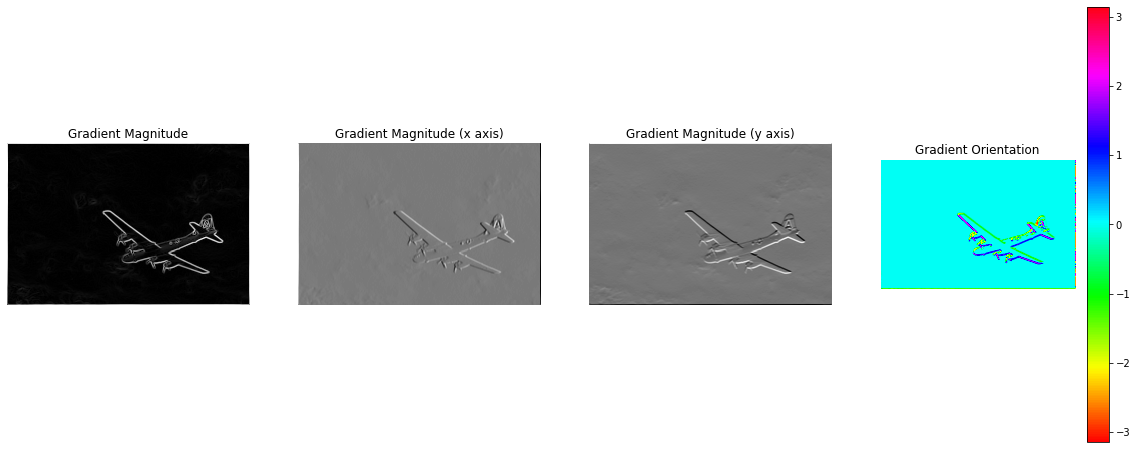

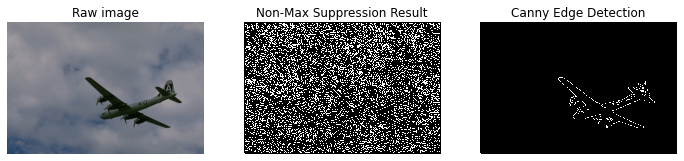

In [14]:
# tuning threshold for a single image
image_folder = "../Images"
save_folder = "../Results" # need to create this folder in the drive
filename='3096.jpg'
I = np.array(Image.open(os.path.join(image_folder, filename)).convert('RGB'))
I_grey = rgb2gray(I)
high = np.mean(I_grey) * 0.35
low = high * 0.4
print("%.3f" % high)
print("%.3f" % low)
E = cannyEdge(I, low, high)
pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')
# check the result in the folder
pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))

# Fill in all tuned threshold to generate edge detection results


Shape Test Passed! 



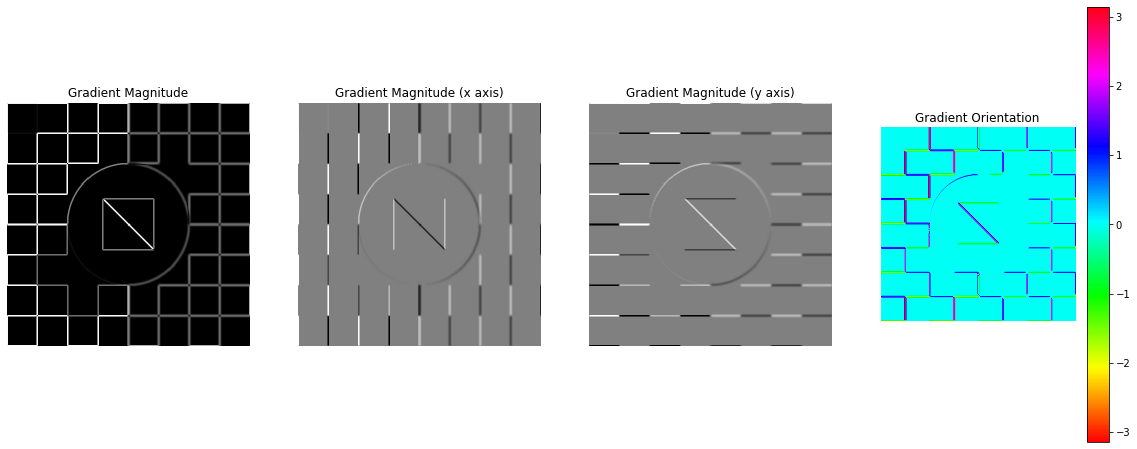

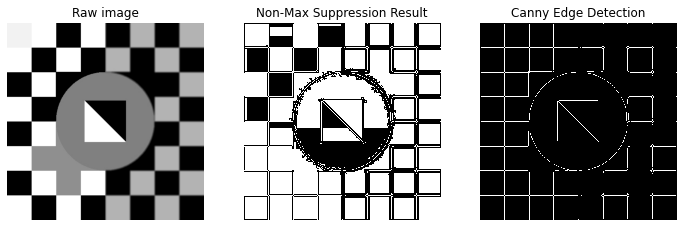

Shape Test Passed! 



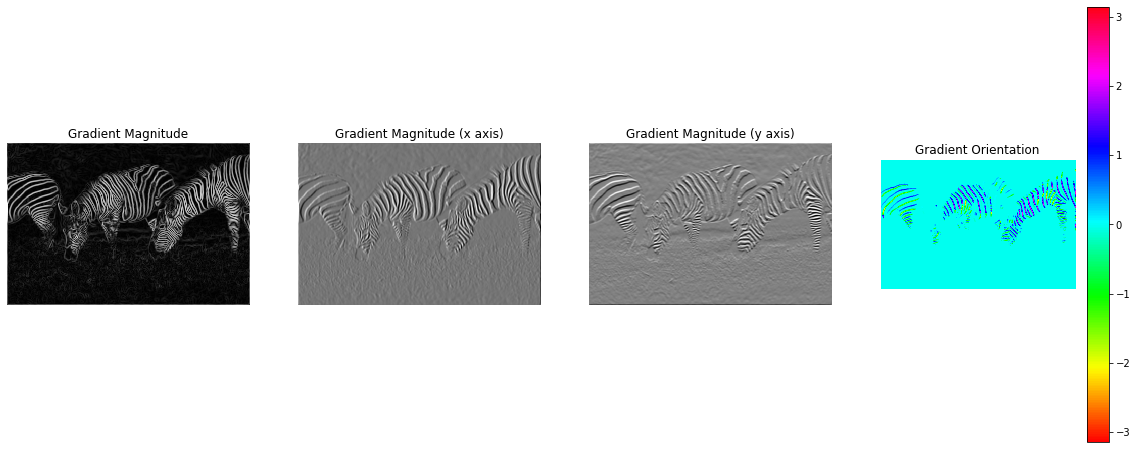

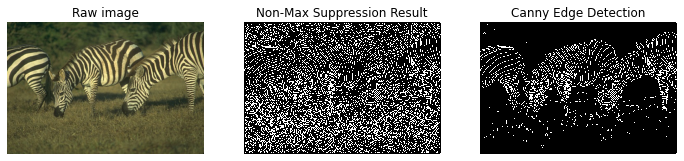

Shape Test Passed! 



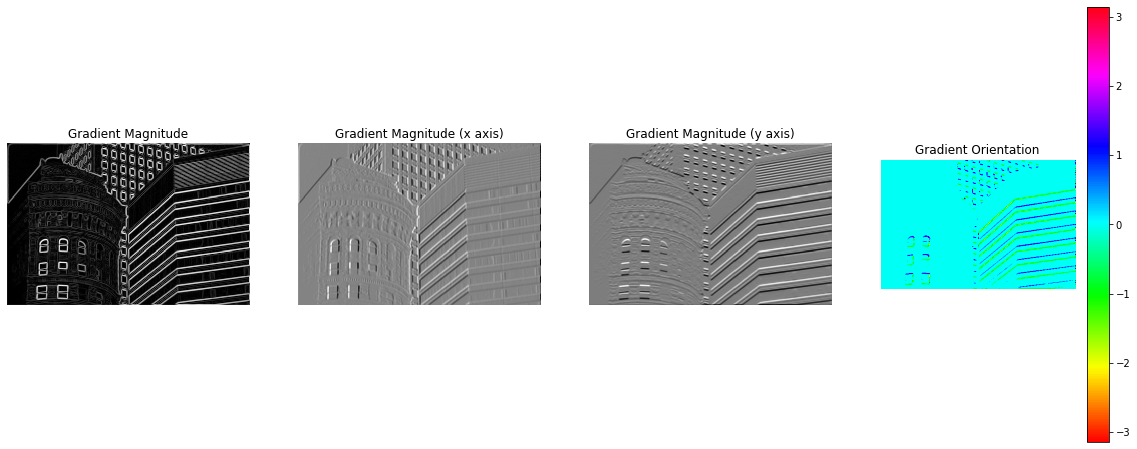

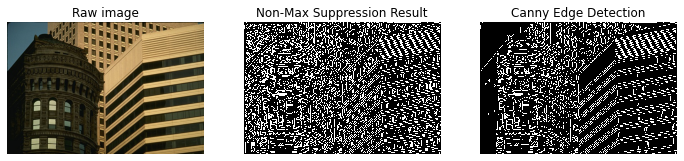

Shape Test Passed! 



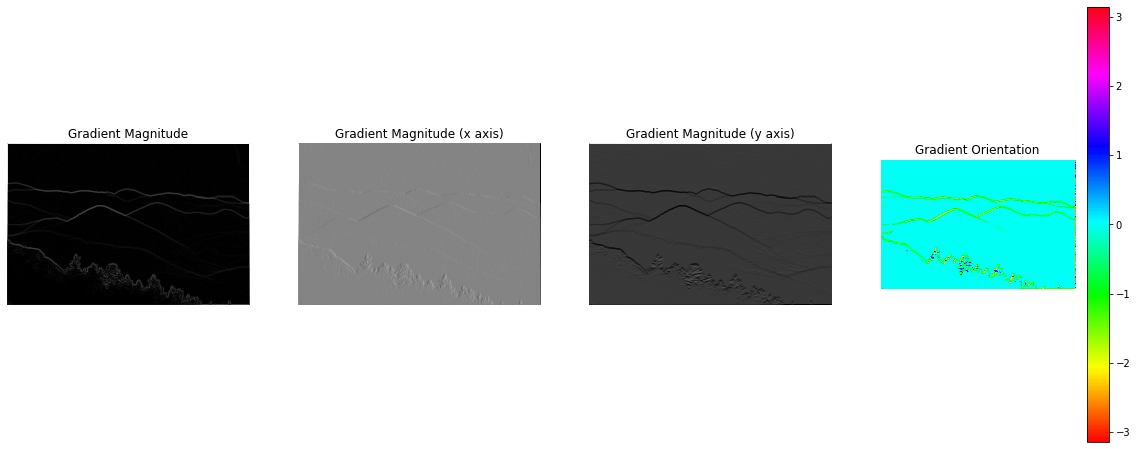

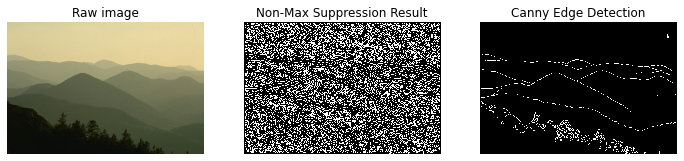

Shape Test Passed! 



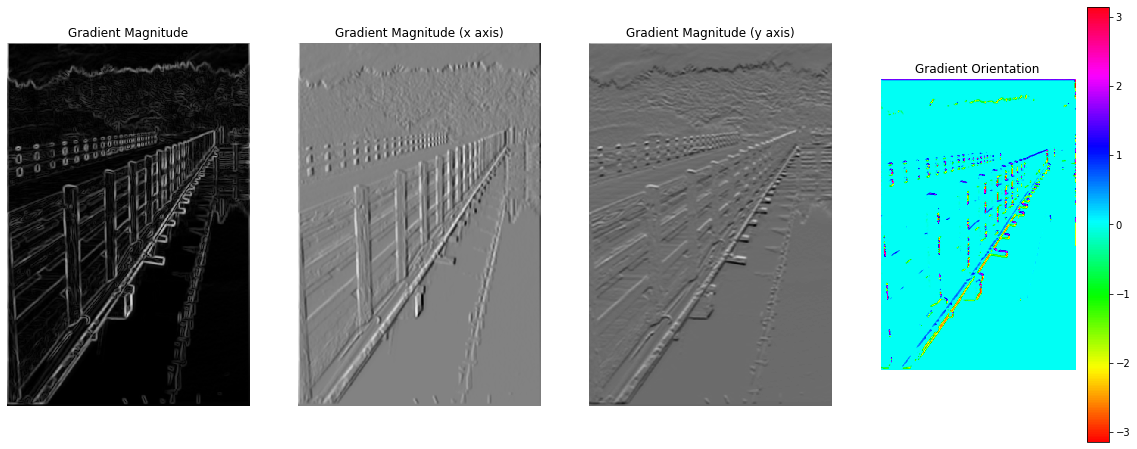

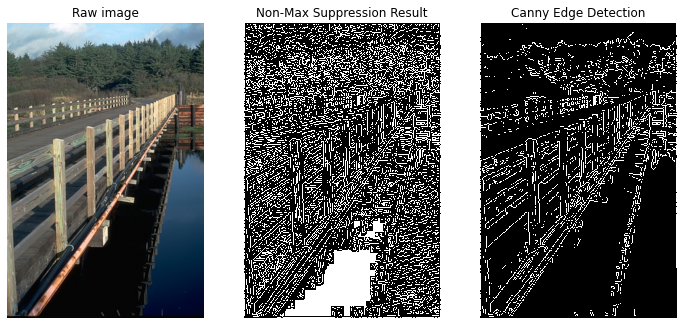

Shape Test Passed! 



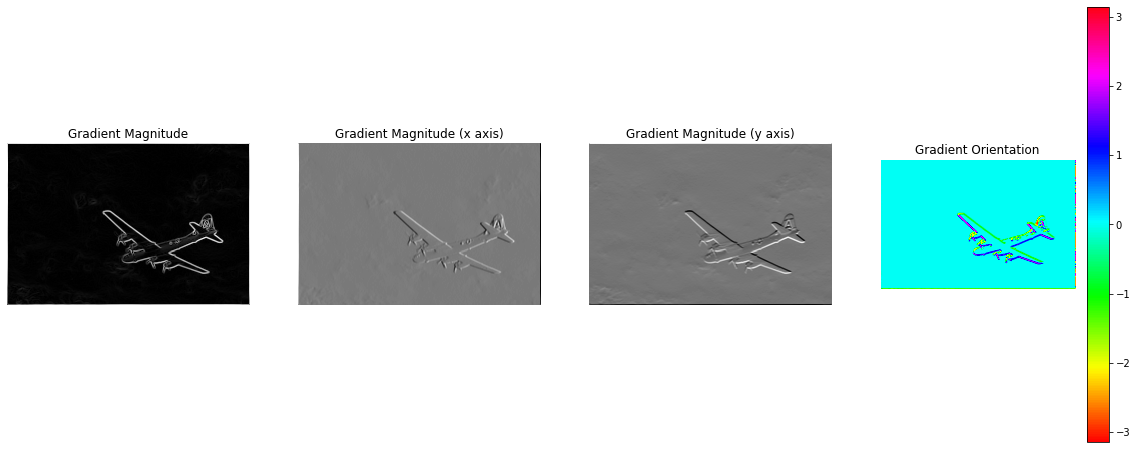

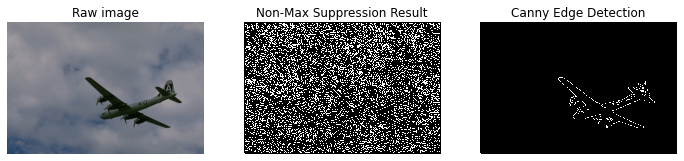

Shape Test Passed! 



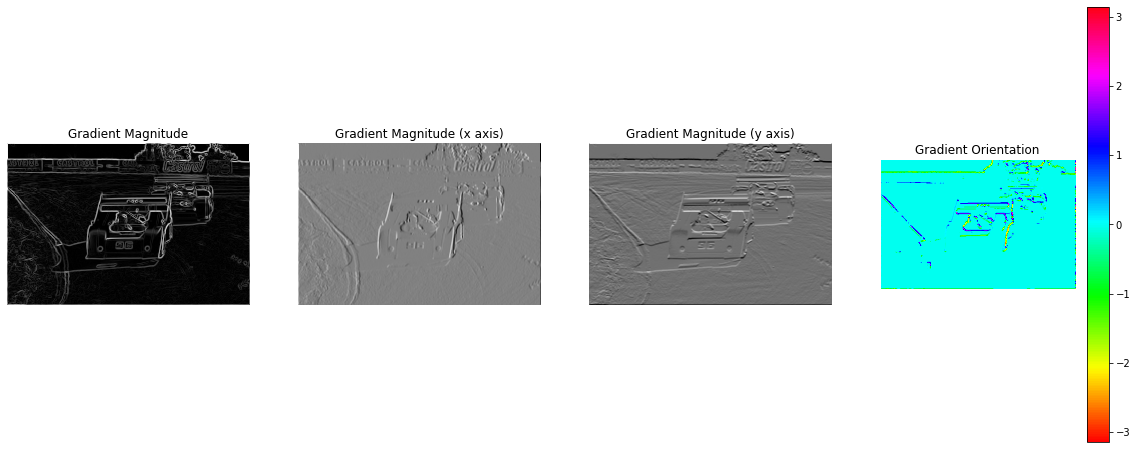

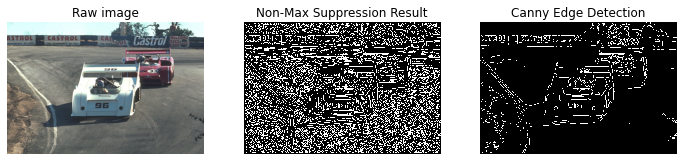

Shape Test Passed! 



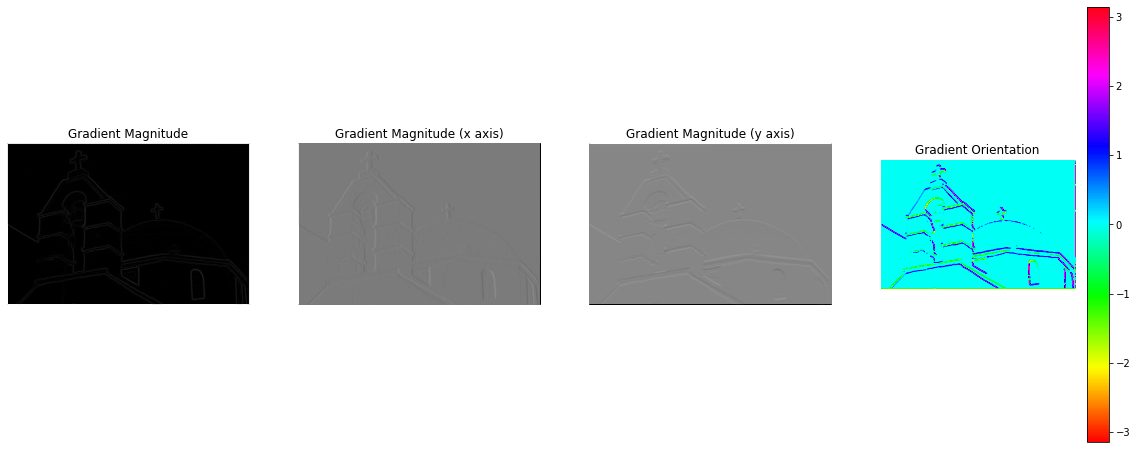

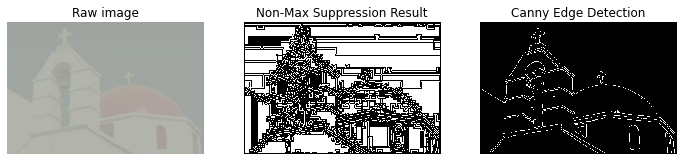

Shape Test Passed! 



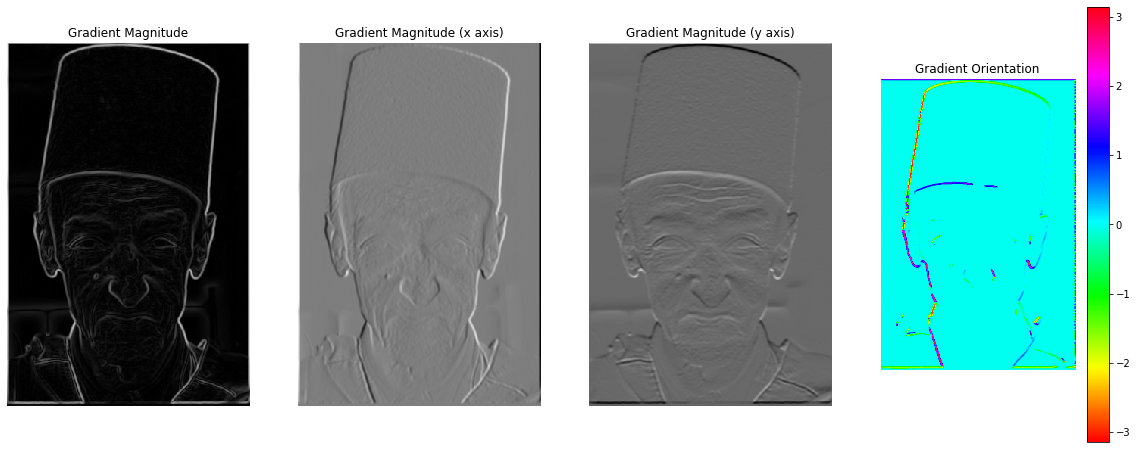

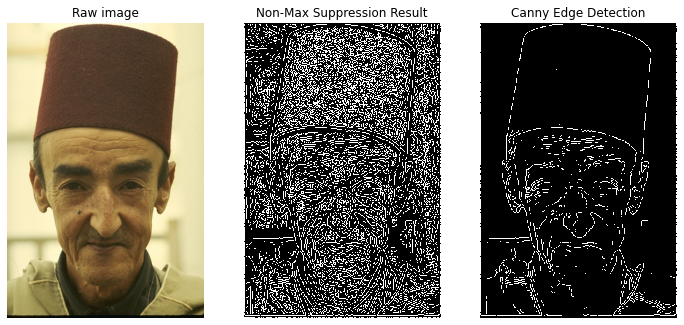

Shape Test Passed! 



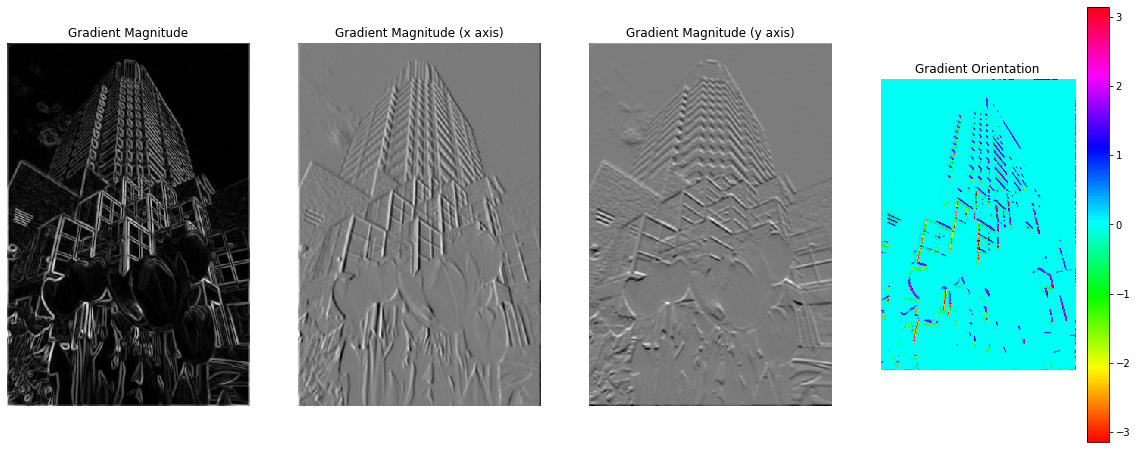

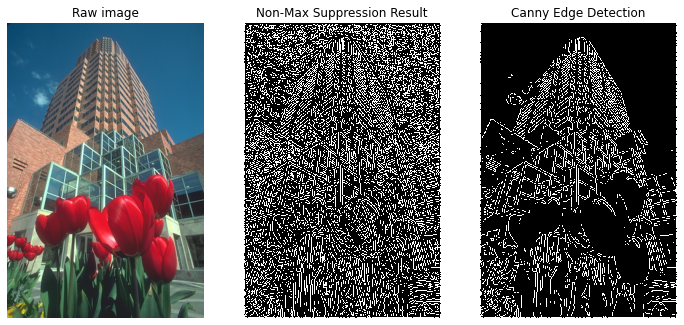

Shape Test Passed! 



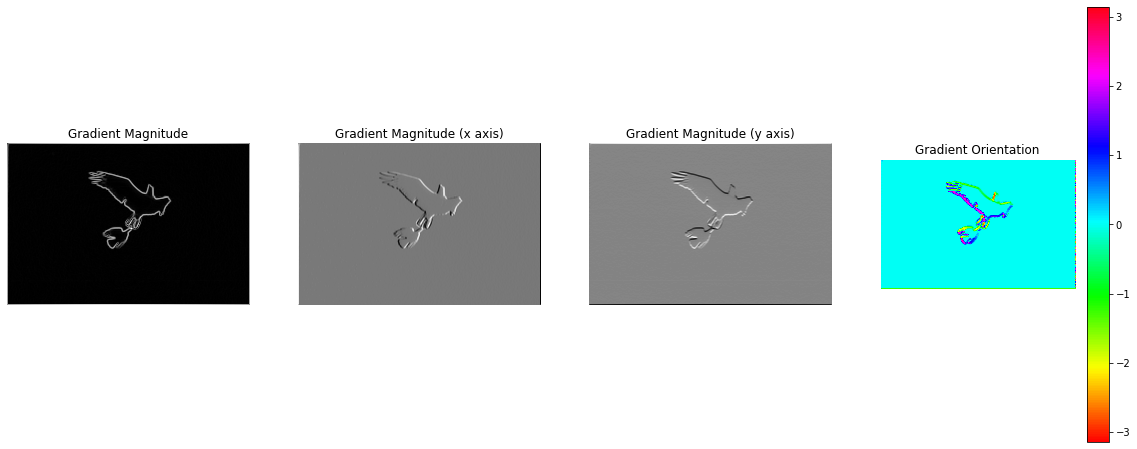

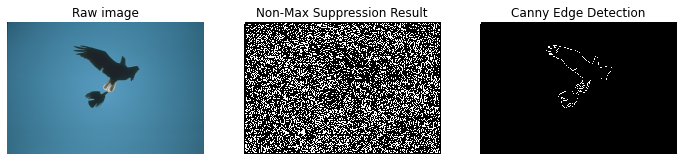

Shape Test Passed! 



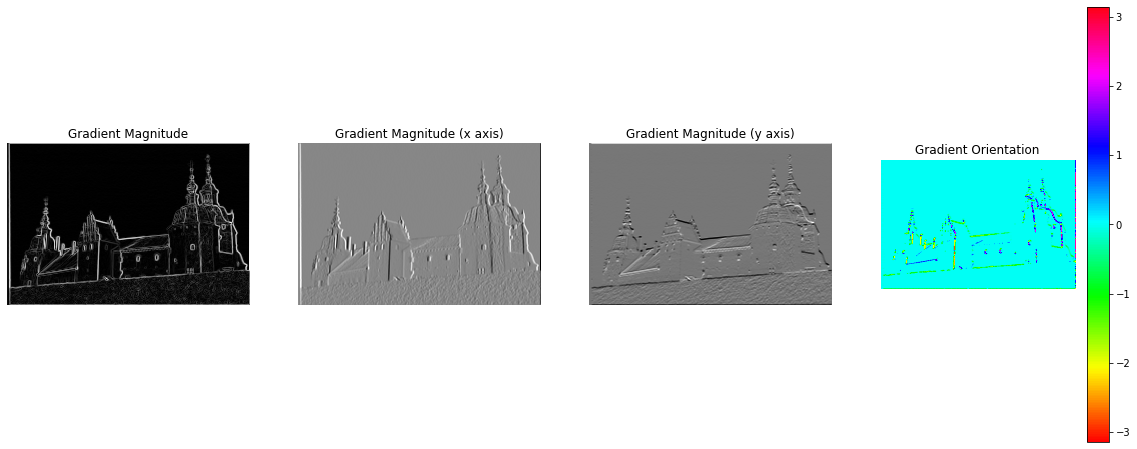

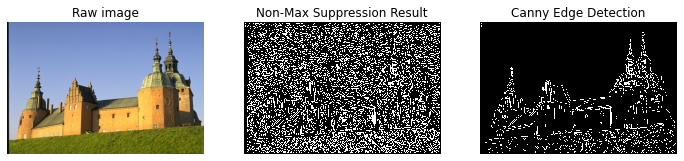

In [ ]:
# keep results for all images
image_folder = "../Images"
save_folder = "../Results"
# fill in the threshold (low, high) you have tuned in the cell above 
thresh_dict = {'118035.jpg': (2.907, 7.267),
                '135069.jpg': (17.575, 43.938),
                '16068.jpg': (17.907, 44.768),
                '189080.jpg': (13.444, 33.610),
                '201080.jpg': (14.866, 37.166),
                '21077.jpg': (24.718, 61.796),
                '22013.jpg': (16.448, 41.119),
                '3096.jpg': (16.552, 41.380),
                '48017.jpg': (9.461, 23.653),
                '55067.jpg': (4.852, 12.131),
                '86000.jpg': (15.339, 38.347),
                'I1.jpg': (6.988, 17.471)}
# generate results one by one
for filename in os.listdir(image_folder):
    # read in image 
    im_path = os.path.join(image_folder, filename)
    I = np.array(Image.open(im_path).convert('RGB'))

    low, high = thresh_dict[filename]
    E = cannyEdge(I, low, high)

    pil_image = Image.fromarray(E.astype(np.uint8) * 255).convert('L')

    pil_image.save(os.path.join(save_folder, "{}_Result.png".format(filename.split(".")[0])))